# CUDA-Q Benchmark: CPU vs GPU Simulation Performance

This notebook measures wall-clock time for quantum circuit simulation on
**CPU** (`qpp-cpu`) vs **GPU** (`nvidia` — NVIDIA cuStateVec) as we scale
two independent axes:

| Experiment | What changes | What stays fixed |
|------------|-------------|-----------------|
| **1 — Depth sweep** | Circuit depth (# layers) | Qubit count |
| **2 — Width sweep** | Qubit count (# qubits) | Circuit depth |

### Why does it matter?

- Classical statevector simulators store **2ⁿ complex numbers** in RAM.
  Doubling the qubit count **doubles** memory and **squares** the state space.
- GPU parallelism helps most when this state vector is large and the per-gate
  computation can be batched across many amplitudes simultaneously.
- There is a **crossover point** below which GPU launch overhead dominates
  and CPU wins; above it, GPU speedup grows rapidly.

### What we measure

`cudaq.sample(circuit, shots_count=N)` — the end-to-end wall-clock time
including state-vector construction, gate application, and shot sampling.
A warmup call is made first to trigger JIT compilation before timing begins.


In [64]:
import cudaq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import warnings

warnings.filterwarnings("ignore")

print(f"CUDA-Q version: {cudaq.__version__}")

# ── GPU availability ──────────────────────────────────────────────────────────
try:
    cudaq.set_target("nvidia")
    cudaq.set_target("qpp-cpu")  # reset
    HAS_GPU = True
    print("GPU target (nvidia / cuStateVec): AVAILABLE ✓")
except Exception as e:
    HAS_GPU = False
    print(f"GPU target not available: {e}")
    print("-> Benchmark will show CPU-only results.")

# ── Benchmark configuration ───────────────────────────────────────────────────
SHOTS    = 1000   # shots per timing run
N_TRIALS = 3      # independent repeats per configuration (median is reported)

# Qubit limits — adjust downward on machines with little RAM/VRAM
MAX_CPU_QUBITS = 15#22   # 2^22 = 4M amplitudes ≈ 64 MB
MAX_GPU_QUBITS = 15#28   # 2^28 = 256M amplitudes ≈ 4 GB VRAM (fp32)

print(f"\nConfig: {SHOTS} shots · {N_TRIALS} trials · median reported")
print(f"  CPU qubit cap:  {MAX_CPU_QUBITS}")
print(f"  GPU qubit cap:  {MAX_GPU_QUBITS}")

# ── Timing helper ─────────────────────────────────────────────────────────────
def run_benchmark(target_name: str, n_qubits: int, depth: int,
                  shots: int = SHOTS, n_trials: int = N_TRIALS) -> float:
    """
    Time cudaq.sample() for brick_wall(n_qubits, depth) on the given target.
    Returns median wall-clock time in seconds, or NaN on failure.
    """
    try:
        cudaq.set_target(target_name)
        # Warmup: compiles kernel and primes GPU caches
        cudaq.get_state(brick_wall, n_qubits, depth)
        

        times = []
        for _ in range(n_trials):
            t0 = time.perf_counter()
            #cudaq.sample(brick_wall, n_qubits, depth, shots_count=shots)
            cudaq.get_state(brick_wall, n_qubits, depth)

            times.append(time.perf_counter() - t0)

        cudaq.set_target("qpp-cpu")
        return float(np.median(times))

    except MemoryError:
        cudaq.set_target("qpp-cpu")
        return np.nan
    except Exception as exc:
        cudaq.set_target("qpp-cpu")
        print(f"    [{target_name}] n={n_qubits} d={depth}: {type(exc).__name__}: {exc}")
        return np.nan

# ── Plotting helpers ───────────────────────────────────────────────────────────
CPU_COLOR = "#000000"   # black
GPU_COLOR = "#76B900"   # NV green
SPD_COLOR = "#637d6d"   #  (grey)


CUDA-Q version: CUDA-Q Version 0.13.0 (https://github.com/NVIDIA/cuda-quantum b66c5bb7fd8c08e5014e2f03e97e7b0e92691650)
GPU target (nvidia / cuStateVec): AVAILABLE ✓

Config: 1000 shots · 3 trials · median reported
  CPU qubit cap:  15
  GPU qubit cap:  15


## The Benchmark Circuit: Brick-Wall HEA

We use a **hardware-efficient ansatz (HEA)** with a brick-wall entanglement
pattern — the most common circuit family in variational quantum algorithms.

```
       H  Rx  Rx  Rx  Rx ...   ← single-qubit layer (per qubit, per depth)
q[0]: ─■──●─────●──────
q[1]: ─■──⊕──●──⊕──●───
q[2]: ─■─────⊕─────⊕───
                   ↑
           CNOT pairs alternate even/odd ("brick wall")
```

**Gate count** per depth-d circuit on n qubits:
- 1 H gate per qubit (initial)
- d × n `Rx(0.3)` single-qubit gates
- d × (n−1) `CNOT` two-qubit gates

**State-vector size** = **2ⁿ** complex float64 values — independent of depth.

**Simulation cost** scales as O(depth × n × 2ⁿ) — linear in depth, exponential in n.


In [65]:
@cudaq.kernel
def brick_wall(n: int, d: int):
    """Brick-wall HEA circuit with n qubits and d entangling layers."""
    q = cudaq.qvector(n)

    # Initial superposition layer
    for i in range(n):
        h(q[i])

    # d alternating layers of Rx + CNOT (even then odd pairs)
    for _ in range(d):
        # Single-qubit rotations
        for i in range(n):
            rx(0.3, q[i])
        # Even CNOT pairs: (0,1), (2,3), (4,5), ...
        for i in range(0, n - 1, 2):
            cx(q[i], q[i + 1])
        # Odd CNOT pairs: (1,2), (3,4), (5,6), ...
        for i in range(1, n - 1, 2):
            cx(q[i], q[i + 1])

    #mz(q)

In [66]:
# ── Define the benchmark kernel ───────────────────────────────────────────────
@cudaq.kernel
def brick_wall(n: int, d: int):
    """Brick-wall HEA circuit with n qubits and d entangling layers."""
    q = cudaq.qvector(n)

    # Initial superposition layer
    for i in range(n):
        h(q[i])

    # d alternating layers of Rx + CNOT (even then odd pairs)
    for _ in range(d):
        # Single-qubit rotations
        for i in range(n):
            rx(0.3, q[i])
        # Even CNOT pairs: (0,1), (2,3), (4,5), ...
        for i in range(0, n - 1, 2):
            cx(q[i], q[i + 1])
        # Odd CNOT pairs: (1,2), (3,4), (5,6), ...
        for i in range(1, n - 1, 2):
            cx(q[i], q[i + 1])

    mz(q)

cudaq.set_target("qpp-cpu")

# Show circuits at a few depths
for d_ex in [1, 3]:
    print(f"n=6 qubits, depth={d_ex}:")
    print(cudaq.draw(brick_wall, 6, d_ex))

# Gate count table
print(f"{'n':>5} {'d':>5} {'H gates':>10} {'Rx gates':>10} {'CNOT gates':>12} {'Total':>8}")
print("-" * 55)
for n in [8, 16, 24]:
    for d in [1, 5, 20]:
        h_g  = n
        rx_g = n * d
        cx_g = (n - 1) * d
        print(f"{n:>5} {d:>5} {h_g:>10} {rx_g:>10} {cx_g:>12} {h_g+rx_g+cx_g:>8}")


n=6 qubits, depth=1:
     ╭───╮╭─────────╮          
q0 : ┤ h ├┤ rx(0.3) ├──●───────
     ├───┤├─────────┤╭─┴─╮     
q1 : ┤ h ├┤ rx(0.3) ├┤ x ├──●──
     ├───┤├─────────┤╰───╯╭─┴─╮
q2 : ┤ h ├┤ rx(0.3) ├──●──┤ x ├
     ├───┤├─────────┤╭─┴─╮╰───╯
q3 : ┤ h ├┤ rx(0.3) ├┤ x ├──●──
     ├───┤├─────────┤╰───╯╭─┴─╮
q4 : ┤ h ├┤ rx(0.3) ├──●──┤ x ├
     ├───┤├─────────┤╭─┴─╮╰───╯
q5 : ┤ h ├┤ rx(0.3) ├┤ x ├─────
     ╰───╯╰─────────╯╰───╯     

n=6 qubits, depth=3:
     ╭───╮╭─────────╮     ╭─────────╮                ╭─────────╮           »
q0 : ┤ h ├┤ rx(0.3) ├──●──┤ rx(0.3) ├─────────────●──┤ rx(0.3) ├───────────»
     ├───┤├─────────┤╭─┴─╮╰─────────╯╭─────────╮╭─┴─╮╰─────────╯╭─────────╮»
q1 : ┤ h ├┤ rx(0.3) ├┤ x ├─────●─────┤ rx(0.3) ├┤ x ├─────●─────┤ rx(0.3) ├»
     ├───┤├─────────┤╰───╯   ╭─┴─╮   ├─────────┤╰───╯   ╭─┴─╮   ├─────────┤»
q2 : ┤ h ├┤ rx(0.3) ├──●─────┤ x ├───┤ rx(0.3) ├──●─────┤ x ├───┤ rx(0.3) ├»
     ├───┤├─────────┤╭─┴─╮   ╰───╯   ├─────────┤╭─┴─╮   ╰───╯   ├─────────┤»
q3

## Experiment 1: Fixed Width, Increasing Depth

**Question**: How does simulation time scale with circuit depth for a fixed qubit count?

- **Fixed**: n = 16 qubits (state vector = 2¹⁶ = 65,536 amplitudes)
- **Varying**: depth d ∈ {1, 2, 4, 8, 16, 32, 64, 128}

### Expected behaviour

Since the **state-vector size is fixed**, each additional depth layer adds a
fixed O(n × 2ⁿ) work increment — so time should grow **linearly** with depth.

- **CPU**: Linear growth, slope determined by single-threaded gate throughput
- **GPU**: Linear growth, but with lower slope (more parallelism per layer)
- **Speedup**: Roughly constant across depths for large circuits;
  GPU overhead dominates at depth=1

At very low depth the circuit is too shallow for GPU to amortise launch costs,
so CPU can be faster. At high depth, GPU throughput wins.


Benchmarking 16-qubit circuit vs depth  (3 trials)

 Depth     CPU (s)     GPU (s)   Speedup
------------------------------------------
     1      0.1461      0.0011   137.77x
     2      0.1705      0.0012   137.10x
     4      0.2180      0.0014   151.04x
     8      0.3279      0.0020   162.96x
    16      0.5167      0.0029   176.79x
    32      0.9211      0.0046   199.06x
    64      1.7504      0.0081   216.70x


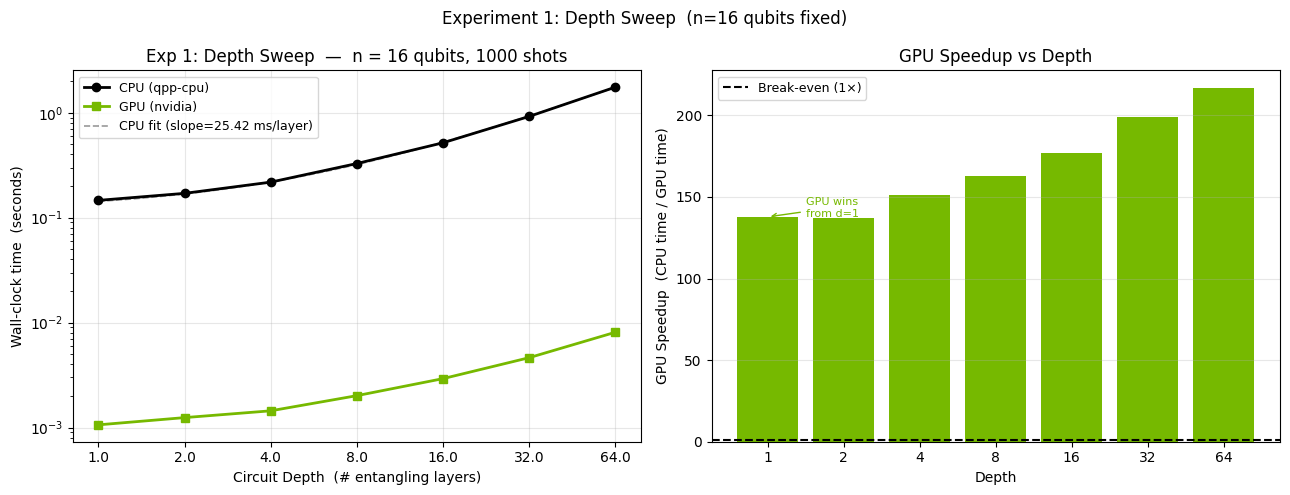

In [67]:
N_FIXED  = 16                                 # fixed qubit count
DEPTHS   = [1, 2, 4, 8, 16, 32, 64]

cpu_times_d = []
gpu_times_d = []

#print(f"Benchmarking {N_FIXED}-qubit circuit vs depth  ({SHOTS} shots · {N_TRIALS} trials)\n")
print(f"Benchmarking {N_FIXED}-qubit circuit vs depth  ({N_TRIALS} trials)\n")
print(f"{'Depth':>6}  {'CPU (s)':>10}  {'GPU (s)':>10}  {'Speedup':>8}")
print("-" * 42)

for d in DEPTHS:
    t_cpu = run_benchmark("qpp-cpu", N_FIXED, d)
    t_gpu = run_benchmark("nvidia",  N_FIXED, d) if HAS_GPU else np.nan

    cpu_times_d.append(t_cpu)
    gpu_times_d.append(t_gpu)

    speedup = t_cpu / t_gpu if (HAS_GPU and not np.isnan(t_gpu) and t_gpu > 0) else np.nan
    sp_str = f"{speedup:.2f}x" if not np.isnan(speedup) else "N/A"
    gpu_str = f"{t_gpu:.4f}" if not np.isnan(t_gpu) else "N/A"
    print(f"{d:>6}  {t_cpu:>10.4f}  {gpu_str:>10}  {sp_str:>8}")

cpu_times_d = np.array(cpu_times_d, dtype=float)
gpu_times_d = np.array(gpu_times_d, dtype=float)
speedup_d   = cpu_times_d / gpu_times_d   # >1 means GPU is faster

# ── Plot ───────────────────────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Left: time vs depth
ax1.plot(DEPTHS, cpu_times_d, "o-", color=CPU_COLOR, lw=2, ms=6, label="CPU (qpp-cpu)")
if HAS_GPU:
    ax1.plot(DEPTHS, gpu_times_d, "s-", color=GPU_COLOR, lw=2, ms=6, label="GPU (nvidia)")

# Fit lines to confirm linear scaling
valid_cpu = ~np.isnan(cpu_times_d)
if valid_cpu.sum() >= 2:
    coeffs = np.polyfit(np.array(DEPTHS)[valid_cpu], cpu_times_d[valid_cpu], 1)
    d_fine = np.linspace(DEPTHS[0], DEPTHS[-1], 200)
    ax1.plot(d_fine, np.polyval(coeffs, d_fine), "--", color=CPU_COLOR,
             alpha=0.4, lw=1.2, label=f"CPU fit (slope={coeffs[0]*1000:.2f} ms/layer)")

ax1.set_xlabel("Circuit Depth  (# entangling layers)")
ax1.set_ylabel("Wall-clock time  (seconds)")
ax1.set_title(f"Exp 1: Depth Sweep  —  n = {N_FIXED} qubits, {SHOTS} shots")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xscale("log", base=2)
ax1.set_yscale("log")
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())

# Right: speedup
if HAS_GPU:
    valid = ~np.isnan(speedup_d) & (np.array(DEPTHS) > 0)
    ax2.bar([str(d) for d in DEPTHS], speedup_d, color=[
        GPU_COLOR if s > 1 else CPU_COLOR
        for s in np.where(np.isnan(speedup_d), 0, speedup_d)])
    ax2.axhline(1.0, color="black", lw=1.5, ls="--", label="Break-even (1×)")
    ax2.set_xlabel("Depth")
    ax2.set_ylabel("GPU Speedup  (CPU time / GPU time)")
    ax2.set_title("GPU Speedup vs Depth")
    ax2.legend(fontsize=9)
    ax2.grid(axis="y", alpha=0.3)
    # Annotate crossover
    crossover_idx = np.where(speedup_d > 1)[0]
    if len(crossover_idx) > 0:
        d_cross = DEPTHS[crossover_idx[0]]
        ax2.annotate(f"GPU wins\nfrom d={d_cross}",
                     xy=(crossover_idx[0], speedup_d[crossover_idx[0]]),
                     xytext=(crossover_idx[0]+0.5, speedup_d[crossover_idx[0]]+0.2),
                     fontsize=8, color=GPU_COLOR,
                     arrowprops=dict(arrowstyle="->", color=GPU_COLOR))
else:
    ax2.text(0.5, 0.5, "GPU not available\non this machine",
             ha="center", va="center", transform=ax2.transAxes,
             fontsize=14, color="gray")
    ax2.set_title("GPU Speedup vs Depth")

plt.suptitle(f"Experiment 1: Depth Sweep  (n={N_FIXED} qubits fixed)", fontsize=12)
plt.tight_layout()
plt.show()


## Experiment 2: Fixed Depth, Increasing Width

**Question**: How does simulation time scale with qubit count for a fixed circuit depth?

- **Fixed**: depth d = 4 layers
- **Varying**: n qubits, from 4 to `MAX_CPU_QUBITS` (CPU) / `MAX_GPU_QUBITS` (GPU)

### Expected behaviour

The state-vector has **2ⁿ** entries → doubling qubits **doubles memory**
and **doubles** compute work (roughly). Time grows **exponentially** with n.

On a log-scale plot we expect straight lines, and the GPU line should have:
- A **higher y-intercept** at small n (GPU overhead costs)
- A **shallower slope** (more parallelism per additional qubit)

The crossover point — where GPU becomes faster — is where the lines intersect.

### Memory footprint

| Qubits | State-vector size (complex128) | RAM required |
|--------|-------------------------------|--------------|
| 16 | 64K amplitudes | 1 MB |
| 20 | 1M amplitudes | 16 MB |
| 24 | 16M amplitudes | 256 MB |
| 28 | 256M amplitudes | 4 GB |
| 30 | 1B amplitudes | 16 GB |

GPU VRAM limits the maximum reachable qubit count with cuStateVec.


CPU sweep (d=10, 1000 shots):  2q 3q 4q 5q 6q 7q 8q 9q 10q 11q 12q 13q 14q 15q 
GPU sweep (d=10, 1000 shots):  2q 3q 4q 5q 6q 7q 8q 9q 10q 11q 12q 13q 14q 15q 

  Qubits     CPU (s)     GPU (s)    Speedup    Mem (MB)
------------------------------------------------------
       2      0.0004      0.0002       1.8x         0.0
       3      0.0004      0.0003       1.4x         0.0
       4      0.0046      0.0006       7.8x         0.0
       5      0.0008      0.0006       1.2x         0.0
       6      0.0008      0.0008       1.1x         0.0
       7      0.0021      0.0010       2.2x         0.0
       8      0.0023      0.0010       2.3x         0.0
       9      0.0029      0.0013       2.3x         0.0
      10      0.0380      0.0014      27.2x         0.0
      11      0.0192      0.0016      12.1x         0.0
      12      0.0532      0.0017      32.1x         0.1
      13      0.0505      0.0020      25.7x         0.1
      14      0.1205      0.0023      53.3x         0.3


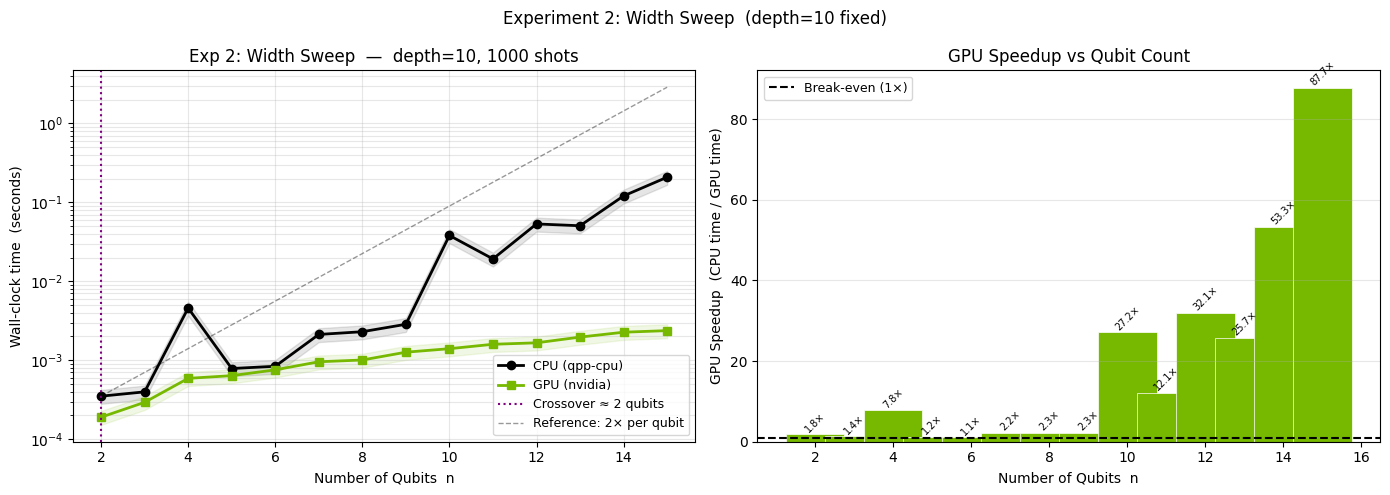

In [68]:
DEPTH_FIXED = 10
CPU_QUBITS  = list(range(2, MAX_CPU_QUBITS + 1, 1))   # even steps
GPU_QUBITS  = list(range(2, MAX_GPU_QUBITS + 1, 1)) if HAS_GPU else []

cpu_times_n = {}
gpu_times_n = {}

# ── CPU sweep ─────────────────────────────────────────────────────────────────
print(f"CPU sweep (d={DEPTH_FIXED}, {SHOTS} shots):  ", end="", flush=True)
for n in CPU_QUBITS:
    t = run_benchmark("qpp-cpu", n, DEPTH_FIXED)
    cpu_times_n[n] = t
    print(f"{n}q ", end="", flush=True)
print()

# ── GPU sweep ─────────────────────────────────────────────────────────────────
if HAS_GPU:
    print(f"GPU sweep (d={DEPTH_FIXED}, {SHOTS} shots):  ", end="", flush=True)
    for n in GPU_QUBITS:
        t = run_benchmark("nvidia", n, DEPTH_FIXED)
        gpu_times_n[n] = t
        print(f"{n}q ", end="", flush=True)
    print()

# ── Results table ─────────────────────────────────────────────────────────────
all_n = sorted(set(CPU_QUBITS + GPU_QUBITS))
print(f"\n{'Qubits':>8}  {'CPU (s)':>10}  {'GPU (s)':>10}  {'Speedup':>9}  {'Mem (MB)':>10}")
print("-" * 54)
for n in all_n:
    t_cpu = cpu_times_n.get(n, np.nan)
    t_gpu = gpu_times_n.get(n, np.nan)
    sp    = t_cpu / t_gpu if (not np.isnan(t_cpu) and not np.isnan(t_gpu) and t_gpu > 0) else np.nan
    mem   = (2**n * 16) / 1e6   # complex128 = 16 bytes

    cpu_s = f"{t_cpu:.4f}" if not np.isnan(t_cpu) else "OOM"
    gpu_s = f"{t_gpu:.4f}" if not np.isnan(t_gpu) else "---"
    sp_s  = f"{sp:.1f}x"   if not np.isnan(sp)    else "---"
    print(f"{n:>8}  {cpu_s:>10}  {gpu_s:>10}  {sp_s:>9}  {mem:>10.1f}")

# ── Plot ───────────────────────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

cpu_n_arr = np.array(CPU_QUBITS)
cpu_t_arr = np.array([cpu_times_n[n] for n in CPU_QUBITS], dtype=float)

ax1.plot(cpu_n_arr, cpu_t_arr, "o-", color=CPU_COLOR, lw=2, ms=6, label="CPU (qpp-cpu)")
ax1.fill_between(cpu_n_arr, cpu_t_arr * 0.8, cpu_t_arr * 1.2,
                 color=CPU_COLOR, alpha=0.1)

if HAS_GPU and gpu_times_n:
    gpu_n_arr = np.array([n for n in GPU_QUBITS if not np.isnan(gpu_times_n.get(n, np.nan))])
    gpu_t_arr = np.array([gpu_times_n[n] for n in gpu_n_arr], dtype=float)
    ax1.plot(gpu_n_arr, gpu_t_arr, "s-", color=GPU_COLOR, lw=2, ms=6, label="GPU (nvidia)")
    ax1.fill_between(gpu_n_arr, gpu_t_arr * 0.8, gpu_t_arr * 1.2,
                     color=GPU_COLOR, alpha=0.1)

    # ── Crossover annotation ──────────────────────────────────────────────────
    common_n = sorted(set(CPU_QUBITS) & set(n for n in GPU_QUBITS if n in gpu_times_n))
    if common_n:
        sp_at_n = {n: cpu_times_n[n] / gpu_times_n[n]
                   for n in common_n
                   if not np.isnan(cpu_times_n[n]) and not np.isnan(gpu_times_n.get(n, np.nan))
                   and gpu_times_n[n] > 0}
        crossover_ns = [n for n, sp in sp_at_n.items() if sp > 1]
        if crossover_ns:
            n_cross = min(crossover_ns)
            ax1.axvline(n_cross, color="purple", lw=1.5, ls=":",
                        label=f"Crossover ≈ {n_cross} qubits")

# Overlay exponential reference (2x per qubit)
ref_n = cpu_n_arr
ref_t = cpu_t_arr[0] * 2.0 ** (ref_n - ref_n[0])
ax1.plot(ref_n, ref_t, "k--", lw=1, alpha=0.4, label="Reference: 2× per qubit")

ax1.set_xlabel("Number of Qubits  n")
ax1.set_ylabel("Wall-clock time  (seconds)")
ax1.set_title(f"Exp 2: Width Sweep  —  depth={DEPTH_FIXED}, {SHOTS} shots")
ax1.set_yscale("log")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, which="both")

# Right panel: speedup vs n (only where both available)
if HAS_GPU and gpu_times_n:
    sp_n = [n for n in common_n if n in sp_at_n]
    sp_v = [sp_at_n[n] for n in sp_n]
    colors_bar = [GPU_COLOR if sp > 1 else CPU_COLOR for sp in sp_v]
    ax2.bar(sp_n, sp_v, width=1.5, color=colors_bar, edgecolor="white", lw=0.5)
    ax2.axhline(1.0, color="black", lw=1.5, ls="--", label="Break-even (1×)")
    ax2.set_xlabel("Number of Qubits  n")
    ax2.set_ylabel("GPU Speedup  (CPU time / GPU time)")
    ax2.set_title("GPU Speedup vs Qubit Count")
    ax2.legend(fontsize=9)
    ax2.grid(axis="y", alpha=0.3)
    # Add text labels on bars
    for n_val, sp_val in zip(sp_n, sp_v):
        ax2.text(n_val, sp_val + 0.05, f"{sp_val:.1f}×",
                 ha="center", va="bottom", fontsize=7, rotation=45)
else:
    ax2.text(0.5, 0.5, "GPU not available\non this machine",
             ha="center", va="center", transform=ax2.transAxes, fontsize=14, color="gray")
    ax2.set_title("GPU Speedup vs Qubit Count")

plt.suptitle(f"Experiment 2: Width Sweep  (depth={DEPTH_FIXED} fixed)", fontsize=12)
plt.tight_layout()
plt.show()


## Scaling Analysis: What the Results Show

### State-Vector Memory Bottleneck

The dominant cost in both experiments is **operating on the 2ⁿ-element state vector**.

```
Time per gate ∝ 2ⁿ   (one pass over the state vector)
Total time    ∝ depth × n_qubits × 2ⁿ
```

The **exponential in n** appears clearly on the log-scale width-sweep plot as
a straight line with slope ≈ log(2) ≈ 0.693 per qubit.

### GPU Advantage: Two Regimes

| Regime | n qubits | Dominant effect |
|--------|----------|-----------------|
| **GPU overhead** | < crossover | Kernel launch, memory transfer setup |
| **GPU wins** | > crossover | 2ⁿ amplitudes processed in parallel by thousands of CUDA cores |

The speedup grows because the GPU has more parallelism to exploit as 2ⁿ grows.

### Depth Scaling Is Linear (as expected)

For a fixed n, each additional gate layer adds O(n × 2ⁿ) work — a constant additive cost.
The log-log depth plot should be linear with slope = 1.

### When to Use Each Backend

| Scenario | Recommendation |
|----------|----------------|
| n < ~18 qubits | `qpp-cpu` — avoids GPU overhead |
| n ≥ 18–22 qubits | `nvidia` — exponential payoff |
| Memory-limited large circuits | `tensornet` — MPS/tree tensor networks |
| Noise simulation | `density-matrix-cpu` (or `-gpu` variant) |
| Multi-node scaling | `nvidia-mgpu` — multi-GPU |


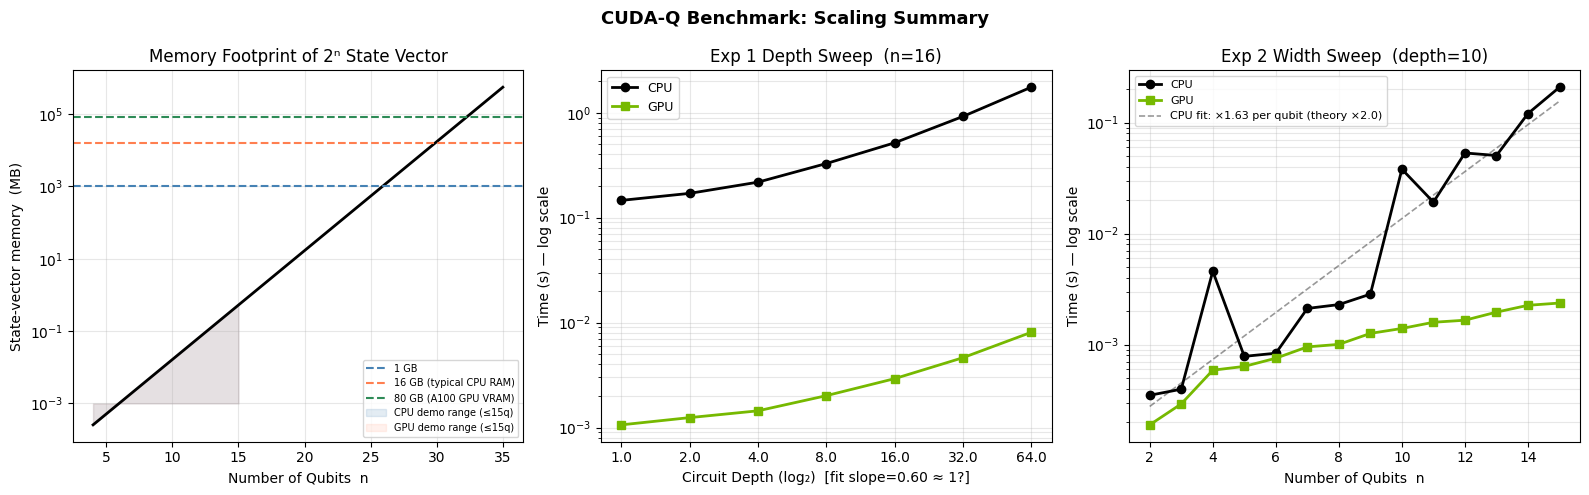

In [69]:
# ── Combined scaling summary plot ──────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Memory footprint
n_range = np.arange(4, 36)
mem_mb  = 2**n_range * 16 / 1e6   # complex128 bytes
axes[0].semilogy(n_range, mem_mb, "k-", lw=2)
axes[0].axhline(1e3,   color="steelblue",  ls="--", lw=1.5, label="1 GB")
axes[0].axhline(16e3,  color="coral",      ls="--", lw=1.5, label="16 GB (typical CPU RAM)")
axes[0].axhline(80e3,  color="seagreen",   ls="--", lw=1.5, label="80 GB (A100 GPU VRAM)")
axes[0].fill_between(n_range, mem_mb, 1e-3,
                     where=(n_range <= MAX_CPU_QUBITS), alpha=0.15, color="steelblue",
                     label=f"CPU demo range (≤{MAX_CPU_QUBITS}q)")
axes[0].fill_between(n_range, mem_mb, 1e-3,
                     where=(n_range <= MAX_GPU_QUBITS), alpha=0.10, color="coral",
                     label=f"GPU demo range (≤{MAX_GPU_QUBITS}q)")
axes[0].set_xlabel("Number of Qubits  n")
axes[0].set_ylabel("State-vector memory  (MB)")
axes[0].set_title("Memory Footprint of 2ⁿ State Vector")
axes[0].legend(fontsize=7)
axes[0].grid(True, alpha=0.3, which="both")

# Panel 2: Depth timing from Exp 1
if len(cpu_times_d) == len(DEPTHS):
    ax = axes[1]
    ax.plot(DEPTHS, cpu_times_d, "o-", color=CPU_COLOR, lw=2, ms=6, label="CPU")
    if HAS_GPU:
        ax.plot(DEPTHS, gpu_times_d, "s-", color=GPU_COLOR, lw=2, ms=6, label="GPU")
    ax.set_xlabel("Circuit Depth (layers)")
    ax.set_ylabel("Time (s) — log scale")
    ax.set_title(f"Exp 1 Depth Sweep  (n={N_FIXED})")
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, which="both")
    # Theory: linear fit in log-log should give slope ≈ 1 for depth axis
    valid = ~np.isnan(cpu_times_d)
    if valid.sum() >= 2:
        coeffs = np.polyfit(np.log2(np.array(DEPTHS)[valid]),
                            np.log2(cpu_times_d[valid]), 1)
        axes[1].set_xlabel(f"Circuit Depth (log₂)  [fit slope={coeffs[0]:.2f} ≈ 1?]")
else:
    axes[1].text(0.5, 0.5, "Run Experiment 1 first",
                 ha="center", va="center", transform=axes[1].transAxes)

# Panel 3: Width timing from Exp 2
if cpu_times_n:
    ax = axes[2]
    cpu_n  = np.array(sorted(cpu_times_n))
    cpu_t2 = np.array([cpu_times_n[n] for n in cpu_n], dtype=float)
    ax.plot(cpu_n, cpu_t2, "o-", color=CPU_COLOR, lw=2, ms=6, label="CPU")

    if HAS_GPU and gpu_times_n:
        gpu_n2 = np.array(sorted(n for n in gpu_times_n if not np.isnan(gpu_times_n[n])))
        gpu_t2 = np.array([gpu_times_n[n] for n in gpu_n2], dtype=float)
        ax.plot(gpu_n2, gpu_t2, "s-", color=GPU_COLOR, lw=2, ms=6, label="GPU")

    # Exponential fit: log(t) = a*n + b → slope ≈ log(2) per qubit
    valid_cpu = ~np.isnan(cpu_t2)
    if valid_cpu.sum() >= 3:
        coeffs = np.polyfit(cpu_n[valid_cpu], np.log2(cpu_t2[valid_cpu]), 1)
        n_fine = np.linspace(cpu_n[0], cpu_n[-1], 200)
        ax.plot(n_fine, 2**np.polyval(coeffs, n_fine), "--",
                color=CPU_COLOR, alpha=0.4, lw=1.2,
                label=f"CPU fit: ×{2**coeffs[0]:.2f} per qubit (theory ×2.0)")
    ax.set_xlabel("Number of Qubits  n")
    ax.set_ylabel("Time (s) — log scale")
    ax.set_title(f"Exp 2 Width Sweep  (depth={DEPTH_FIXED})")
    ax.set_yscale("log")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, which="both")
else:
    axes[2].text(0.5, 0.5, "Run Experiment 2 first",
                 ha="center", va="center", transform=axes[2].transAxes)

plt.suptitle("CUDA-Q Benchmark: Scaling Summary", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()


## Summary

### Key Results

| Experiment | CPU scaling | GPU scaling | Crossover |
|------------|-------------|-------------|-----------|
| Depth (fixed n) | Linear | Linear, lower slope | Low depth |
| Width (fixed d) | Exponential (×2/qubit) | Exponential (×2/qubit), lower constant | ~18–22 qubits |

### Rules of Thumb for CUDA-Q Target Selection

```python
# Small circuits (n < ~18):
cudaq.set_target("qpp-cpu")          # GPU overhead dominates

# Medium-large circuits (n ≥ ~18):
cudaq.set_target("nvidia")           # cuStateVec FP32

# High-precision needed:
cudaq.set_target("nvidia-fp64")      # cuStateVec FP64

# Very large (n > ~30) or long-range correlations:
cudaq.set_target("tensornet")        # cuTensorNet — MPS

# Multi-GPU cluster:
cudaq.set_target("nvidia", option="mgpu")   # multi-GPU statevector

# Noise simulation:
cudaq.set_target("density-matrix-cpu")      # density matrix (CPU)
```

### Switching Is Free

The same kernel — zero code changes:
```python
@cudaq.kernel
def my_circuit(n: int):
    q = cudaq.qvector(n)
    ...

cudaq.set_target("qpp-cpu");  cudaq.sample(my_circuit, 12)  # CPU
cudaq.set_target("nvidia");   cudaq.sample(my_circuit, 25)  # GPU  ← same kernel
```

### What's Not Captured Here

- **Noise simulation**: density matrix has (2ⁿ)² memory → half the qubit reach
- **Shot overhead**: at low depth, shot-sampling dominates over gate cost
- **First-call JIT**: warmup was used here to exclude compilation from timing
- **Memory bandwidth**: GPU DRAM bandwidth often limits real throughput, not FLOP count
